In [1]:
pip uninstall opencv-python -y opencv-contrib-python -q

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install opencv-contrib-python opencv-python ultralytics -U ipywidgets -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 0.22.0 requires google-cloud-bigquery[bqstorage,pandas]>=3.10.0, but you have google-cloud-bigquery 2.34.4 which is incompatible.
bigframes 0.22.0 requires google-cloud-storage>=2.0.0, but you have google-cloud-storage 1.44.0 which is incompatible.
bigframes 0.22.0 requires pandas<2.1.4,>=1.5.0, but you have pandas 2.2.3 which is incompatible.
dataproc-jupyter-plugin 0.1.79 requires pydantic~=1.10.0, but you have pydantic 2.9.2 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


# Renue: детекция пластиковых отходов

**Заказчик**

Renue – IT-компания из Екатеринбурга, разрабатывает высоконагруженные и отказоустойчивые решения для крупных российских заказчиков, для бизнеса и государства.


**Цель работы:** разработать модель для детекции и классификации различных типов
пластиковых отходов на кадрах с конвейерной ленты. Задача заключается в распознавании
объектов на предоставленных изображениях (фреймах) и повышении точности
классификации для дальнейшей автоматизации сортировки отходов.


**Данные**
Заказчик предоставляет датасет (изображения + разметка)

Набор данных содержит изображения, снятые с камер, установленных над сортировочным конвейером на перерабатывающем заводе.


**Метрика**

Для оценки качества модели используется`mAP` -  среднее взвешенное по классам (weighted mean by class support).

**Файлы**
-
images: Папка, содержащая 9000 изображений. Каждое изображение представляет кадр с конвейерной ленты, на котором видны отходы различных типов
- train.csv: CSV-файл, содержащий разметку для обучения модели. Каждая строка включает:
    - `file_name`: имя файла
    - `bbox`: рамка в формате [x_left, y_top, width, height]
    - `category_id`: класс объекта, присутствующего на изображении
- test.csv: Файл, содержащий имена изображений для тестирования. Эти изображения необходимо классифицировать с помощью разработанных моделей
- sample_submission.csv: Пример файла для отправки решений:
    - `file_name`: имя файла
    - `bbox`: рамка в формате [x_left, y_top, width, height]

**Классы объектов:**

Набор данных включает 15 классов пластиковых отходов:

* 1 PET (transparent) (green)
* 2 PET (transparent) (brown)
* 3 PET (transparent) (blue)
* 4 PET (transparent)
* 5 PET (transparent) (dark blue)
* 6 PET (black)
* 7 PET (white)
* 8 PET (sticker)
* 9 PET (flacon)
* 10 PET (household chemicals)
* 11 PND (household chemicals)
* 12 PND packet
* 13 Other plastic
* 14 Other plastic (transparent)
* 15 Not plastic

**План работы:**
* Ознакомиться с датасетом и подготовить данные для обучения модели.
* Исследовать существующие решения по детекции объектов, выбрать подходящую модель.
* Обучить модель, сравнить несколько подходов (например, использование предобученных моделей).
* Провести тестирование на предоставленных материалах.
* Провести анализ результатов и предложить возможные улучшения модели.

## 1. Загрузка данных и знакомство с ними

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import json
import ultralytics
import shutil
import math
import gc
import yaml

from ultralytics import YOLO
from ultralytics.utils.ops import xywh2ltwh
from sklearn.utils import shuffle

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [4]:
RANDOM_STATE = 241124
PATH = '/kaggle/input/waste-detection/'
YAML_PATH = '/kaggle/input/data-yaml-from-input/data.yaml'
IMGSZ = 1024
WIDTH = 2048
HEIGTH = 1486

In [5]:
data = pd.read_csv(os.path.join(PATH, 'train.csv'))
test = pd.read_csv(os.path.join(PATH, 'test.csv'))
sample_submission = pd.read_csv(os.path.join(PATH, 'sample_submission.csv'))

In [6]:
data.info()
data.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32265 entries, 0 to 32264
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   file_name    32265 non-null  object 
 1   bbox         32148 non-null  object 
 2   category_id  32148 non-null  float64
dtypes: float64(1), object(2)
memory usage: 756.3+ KB


file_name                                        bbox  category_id
0  000001.jpg                  [840.0, 0.0, 176.0, 124.0]          4.0
1  000001.jpg                [612.0, 306.0, 383.0, 397.0]          2.0
2  000001.jpg  [990.92, 551.0, 105.00000000000011, 186.0]          4.0
3  000002.jpg                [1000.0, 614.0, 98.0, 178.0]          4.0
4  000002.jpg                [605.0, 358.0, 402.0, 409.0]          2.0
5  000002.jpg                  [838.0, 0.0, 164.0, 184.0]          4.0
6  000004.jpg                [1002.0, 728.0, 91.0, 178.0]          4.0
7  000004.jpg                [618.0, 489.0, 377.0, 387.0]          2.0
8  000004.jpg                  [822.0, 0.0, 197.0, 285.0]          4.0
9  000005.jpg                [1003.0, 789.0, 89.0, 173.0]          4.0

In [7]:
data['file_name'].nunique()

6001

In [8]:
test.info()
test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2999 entries, 0 to 2998
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  2999 non-null   object
dtypes: object(1)
memory usage: 23.6+ KB


file_name
0  000003.jpg
1  000006.jpg
2  000013.jpg
3  000016.jpg
4  000019.jpg

In [9]:
sample_submission.info()
sample_submission.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2999 entries, 0 to 2998
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  2999 non-null   object
 1   bbox       2999 non-null   object
dtypes: object(2)
memory usage: 47.0+ KB


file_name                                               bbox
0  000003.jpg  [[5.0, 0.64, 536.1, 76.56, 834.52, 890.82], [5...
1  000006.jpg  [[4.0, 0.91, 397.68, 3.2, 218.05, 970.42], [4....
2  000013.jpg                                                 []
3  000016.jpg  [[8.0, 0.89, 587.89, 771.75, 636.26, 337.43], ...
4  000019.jpg  [[7.0, 0.68, 75.08, 220.41, 982.22, 794.76], [...

**Вывод по первому шагу:** загрузили и провели первичный обзор данных.

Набор данных `train.csv` сдержит 32265 строк и 6001 уникальное изображение, столбцы `bbox` и `category_id` имеют пропуски. Вероятно, это связано с тем, что на фото пустой конвейер, проверим это на следующем шаге.

`test.csv` содержит 2999 изображений для детекции.

Пример решения `sample_submission` содержит те же 2999 изображений, что и `test.csv`. Стоит отметить, что предсказание может иметь список списков, что говорит о нескольких объектах на одном фото, либо пустой список, что свидетельствует о пустом конвейере.

## 2. Анализ данных

Проверим данные на пропуски.

In [10]:
data.isna().sum()

file_name        0
bbox           117
category_id    117
dtype: int64

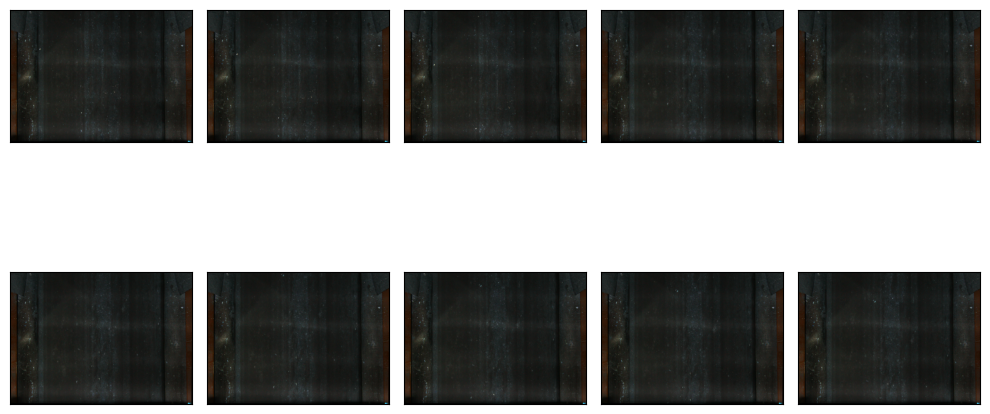

In [11]:
nan_sample = data[data['category_id'].isna()].reset_index(drop=True)

fig = plt.figure(figsize=(10,10))
for i in range(10):
    fig.add_subplot(2, 5, i+1)
    path = os.path.join(PATH, 'images', nan_sample['file_name'][i])

    image = cv2.imread(path)
   
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

Видим, что пропуски в данных говорят о том, что конвейерная лента была пустой.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


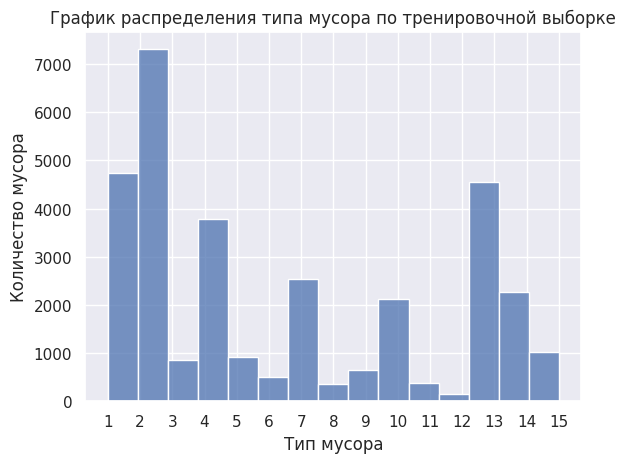

In [14]:
sns.set_theme(style='darkgrid')

sns.histplot(data=data.dropna(), x='category_id', bins=15)
plt.title('График распределения типа мусора по тренировочной выборке')
plt.xlabel('Тип мусора')
plt.ylabel('Количество мусора')
plt.xticks(data['category_id'].dropna().unique())
plt.show()

Классы распределены неравномерно. Чаще всего на конвейере встречается мусор категории 2, реже всего - категория 12 либо конвейер вовсе остается пустым.

In [32]:
category_dict = {
      1: 'PET (transparent) (green)',
      2: 'PET (transparent) (brown)',
      3: 'PET (transparent) (blue)',
      4: 'PET (transparent)',
      5: 'PET (transparent) (dark blue)',
      6: 'PET (black)',
      7: 'PET (white)',
      8: 'PET (sticker)',
      9: 'PET (flacon)',
      10: 'PET (household chemicals)',
      11: 'PND (household chemicals)',
      12: 'PND packet',
      13: 'Other plastic',
      14: 'Other plastic (transparent)',
      15: 'Not plastic'
}

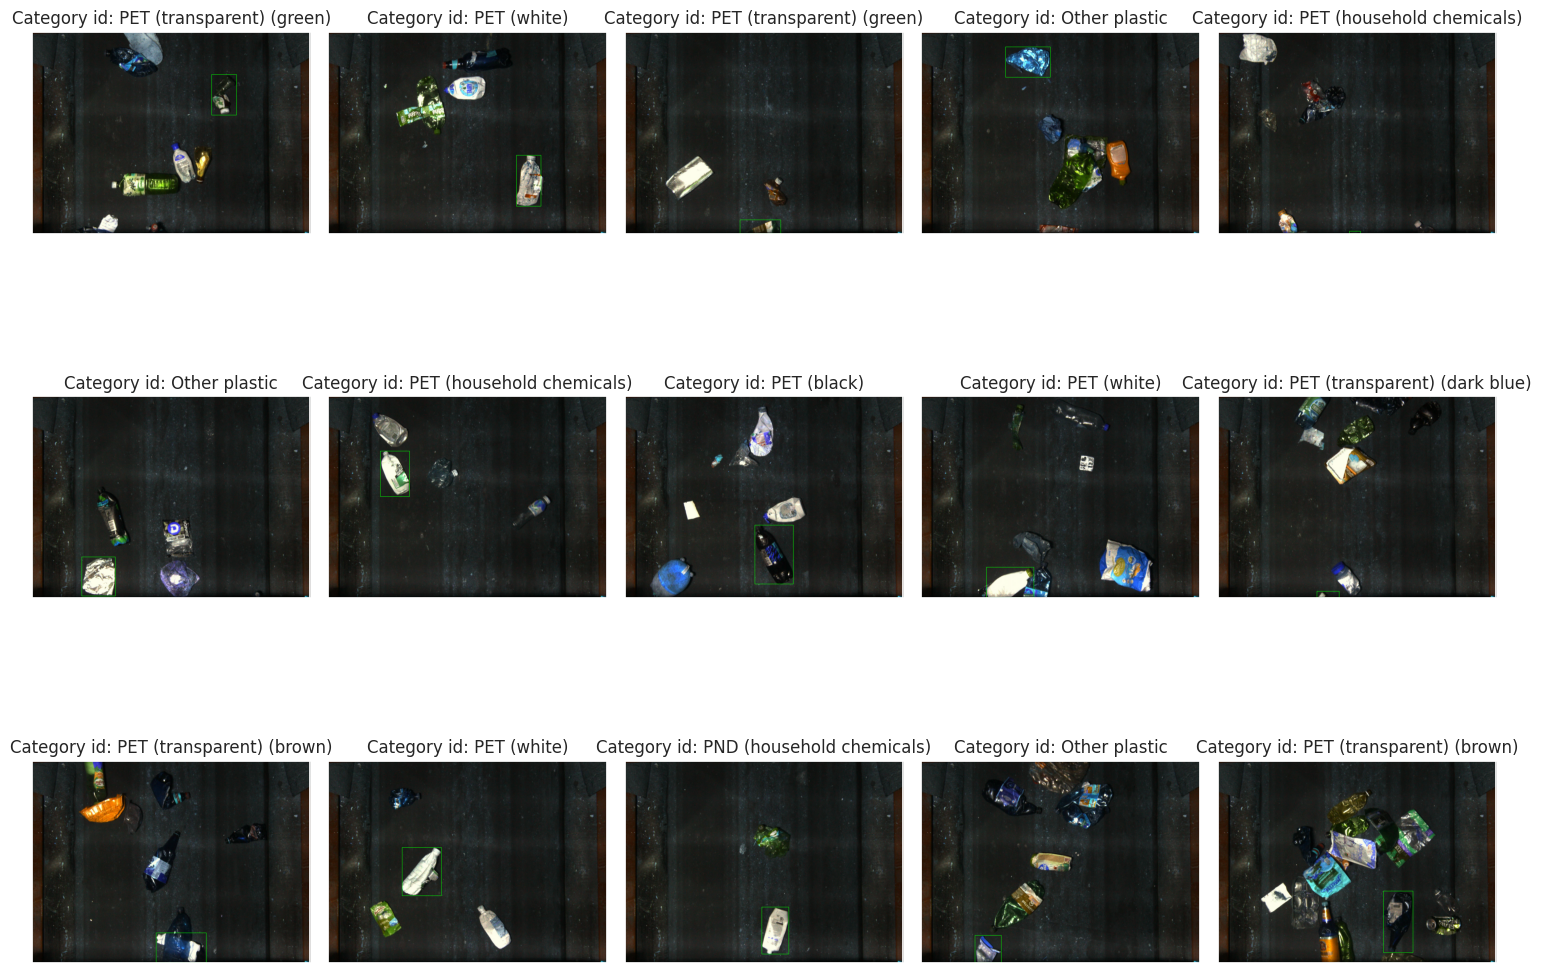

In [33]:
train_sample = data.sample(n=15, replace=True, ignore_index=True, random_state=RANDOM_STATE)

fig = plt.figure(figsize=(15,15))
for i in range(len(train_sample)):
    fig.add_subplot(3, 5, i+1)
    # для корректного изъятия списка из колонки использую json.loads
    position_list = json.loads(train_sample['bbox'][i])
    path = os.path.join(PATH, 'images', train_sample['file_name'][i])

    image = cv2.imread(path)
    # задаем начальную и конечную координату рамки вокруг объекта
    start_point = (int(position_list[0]), int(position_list[1]))
    end_point = (int(position_list[0] + position_list[2]), int(position_list[1] + position_list[3]))

    # зеленый цвет рамки в формате BGR и её толщина
    color = (0, 255, 0)
    thickness = 2
    # создаем рамку вокруг изображения
    image = cv2.rectangle(image, start_point, end_point, color, thickness)

    plt.imshow(image)
    category = category_dict[int(train_sample['category_id'][i])]
    plt.title(f'Category id: {category}')
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

Можем заметить, что набор картинок достаточно разнообразен. Имеются различные типы отходов, расположенные на конвейере в случайном положении. Стоит отметить, что количество отходов на одном фото варьируется от 0 до нескольких.

**Вывод по второму шагу:** определили, что классы распределены неравномерно. Чаще всего на конвейере встречается мусор категории 2, реже всего - категория 12 либо конвейер вовсе остается пустым.

Рассмотрели выборку фото с конвейера. Набор картинок достаточно разнообразен. Имеются различные типы отходов, расположенные на конвейере в случайном положении. Стоит отметить, что количество отходов на одном фото варьируется от 0 до нескольких.

## 3. Обучение модели

### 3.1 Подготовка данных для YOLO (выполнено один раз, далее подаем результат на вход модели)

Для yolo требуется нумерация классов с нуля, поэтому вычтем единицу из исходного набора классов.

In [ ]:
 #data['category_id'] = data['category_id'] - 1

In [ ]:
'''images_folder = os.path.join(PATH, 'images')
train_labels_file = os.path.join(PATH, 'train.csv')
test_labels_file = os.path.join(PATH, 'test.csv')
output_folder = os.path.join('datasets', 'yolo11')
output_folder_images = os.path.join(output_folder, 'images')
output_folder_labels = os.path.join(output_folder, 'labels')'''

In [ ]:
'''if not os.path.exists(output_folder):
    os.makedirs(output_folder)'''

Выделим тренировочный и валидационный датасеты, не забыв учесть повторяющиеся изображения.

In [ ]:
'''unique_img = data['file_name'].unique().tolist()
unique_img = shuffle(unique_img, random_state=RANDOM_STATE)
split_index = int(len(unique_img) * 0.8)
train_list = unique_img[:split_index]
val_list = unique_img[split_index:]

train = data[data['file_name'].isin(train_list)]
val = data[data['file_name'].isin(val_list)]

train.sort_index(inplace=True)
val.sort_index(inplace=True)'''

Код для сортировки картинок и текствых файлов по папкам.

In [ ]:
'''def yolo_directory(data):
    for index, row in data.iterrows():
        file_name = row['file_name']
        if data.equals(train) or data.equals(val):
            bbox = row['bbox']
            category = row['category_id']
    
        image_path = os.path.join(images_folder, file_name)
        if data.equals(train):
            data_images_folder = os.path.join(output_folder_images, 'train')
            data_labels_folder = os.path.join(output_folder_labels, 'train')
        if data.equals(val):
            data_images_folder = os.path.join(output_folder_images, 'val')
            data_labels_folder = os.path.join(output_folder_labels, 'val')
        if data.equals(test):
            data_images_folder = os.path.join(output_folder_images, 'test')
            data_labels_folder = os.path.join(output_folder_labels, 'test')
            
        
        if not os.path.exists(data_images_folder):
            os.makedirs(data_images_folder, exist_ok=True)
    
        if not os.path.exists(data_labels_folder):
            os.makedirs(data_labels_folder, exist_ok=True)
    
        if os.path.exists(image_path):
            shutil.copy(image_path, data_images_folder)
    
            txt_file_path = os.path.join(data_labels_folder, 
                                         f'{os.path.splitext(file_name)[0]}.txt')
            
            if data.equals(train) or data.equals(val):
                if math.isnan(category):
                    with open(txt_file_path, 'a') as txt_file:
                        txt_file.write('')
                else:
                    bbox = json.loads(bbox)
                    x_centr = bbox[0] + (bbox[2] / 2)
                    y_centr = bbox[1] + (bbox[3] / 2)
                    x_norm = x_centr / WIDTH
                    y_norm = y_centr / HEIGTH
                    w_norm = bbox[2] / WIDTH
                    h_norm = bbox[3] / HEIGTH
                    with open(txt_file_path, 'a') as txt_file:
                        txt_file.write(f'{category} {x_norm} {y_norm} {w_norm} {h_norm}\n')
                
                
    print('Создание директории с файлами завершено')'''

In [ ]:
#yolo_directory(train)

In [ ]:
#yolo_directory(val)

In [ ]:
#yolo_directory(test)

### 3.2 Тренировка модели

In [ ]:
model = YOLO('yolo11s.pt')

In [ ]:
yaml_path = os.path.join(YAML_PATH)

In [ ]:
results = model.train(
    data=yaml_path,
    epochs=150,
    patience=10,
    batch=20,
    #cos_lr=True,
    lr0=0.0001, 
    lrf=0.1,
    imgsz=IMGSZ,
    plots=True,
    auto_augment='augmix',
    seed=RANDOM_STATE,
    #hsv_h=0.025,
    hsv_s=0.6,
    #hsv_v=0.5,
    #degrees=0.3,
    #perspective=0.0002,
    #flipud=0.3,
    #bgr=0.1,
    #mixup=0.1,
    #erasing=0.3
    )

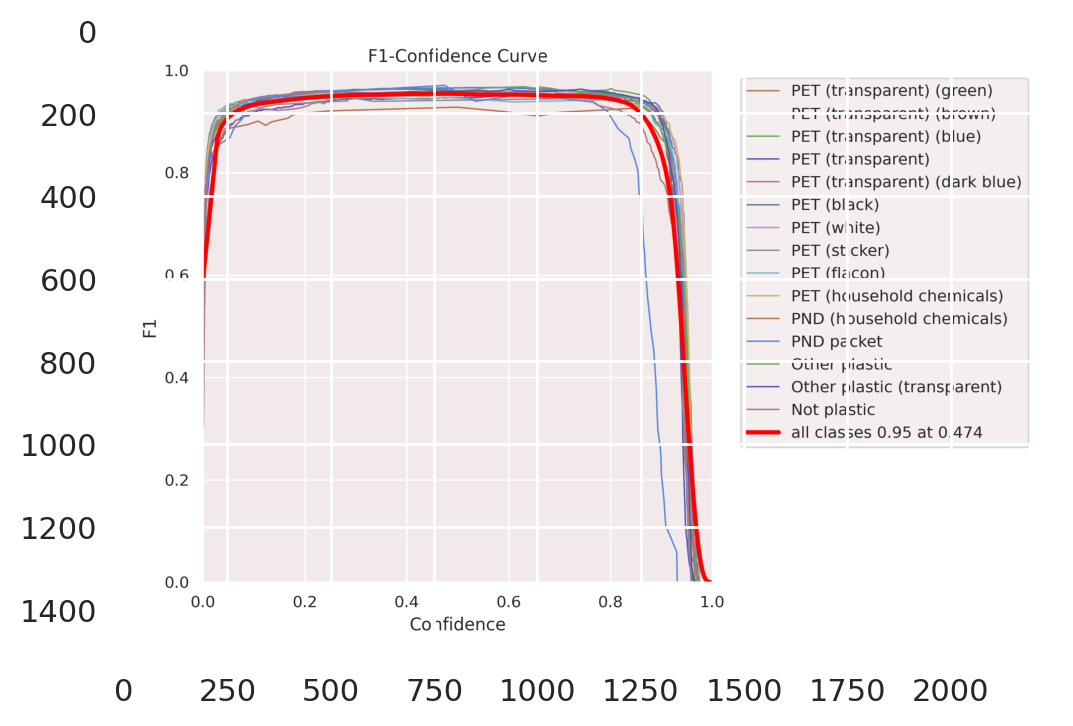

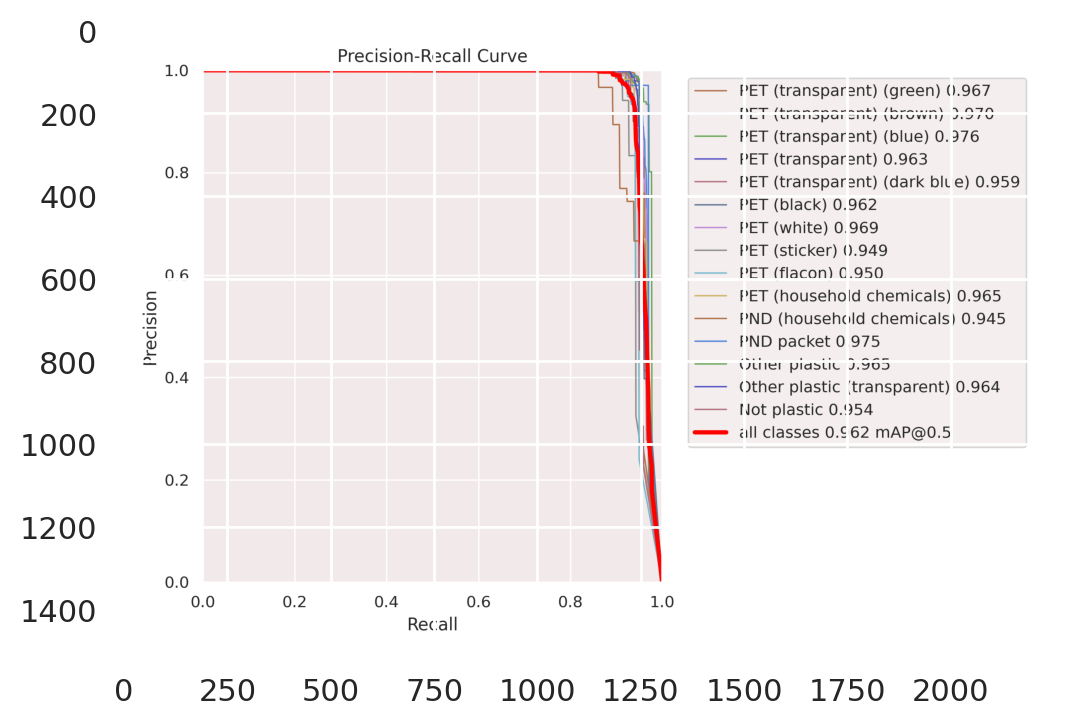

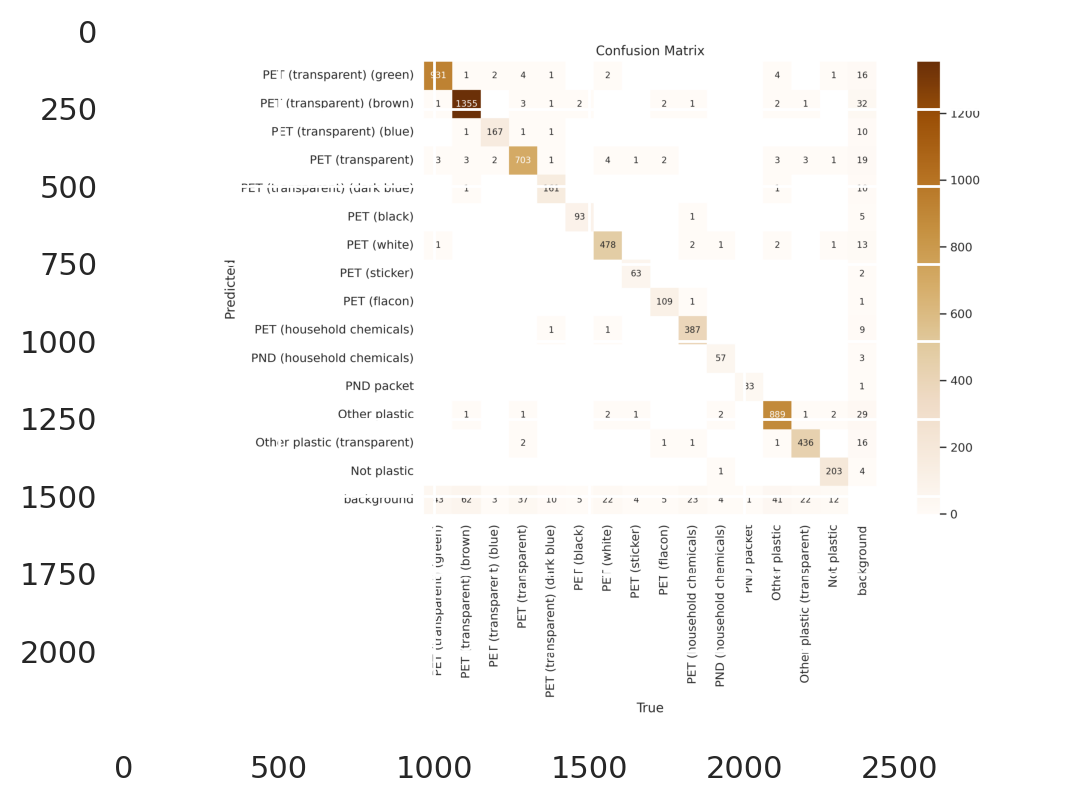

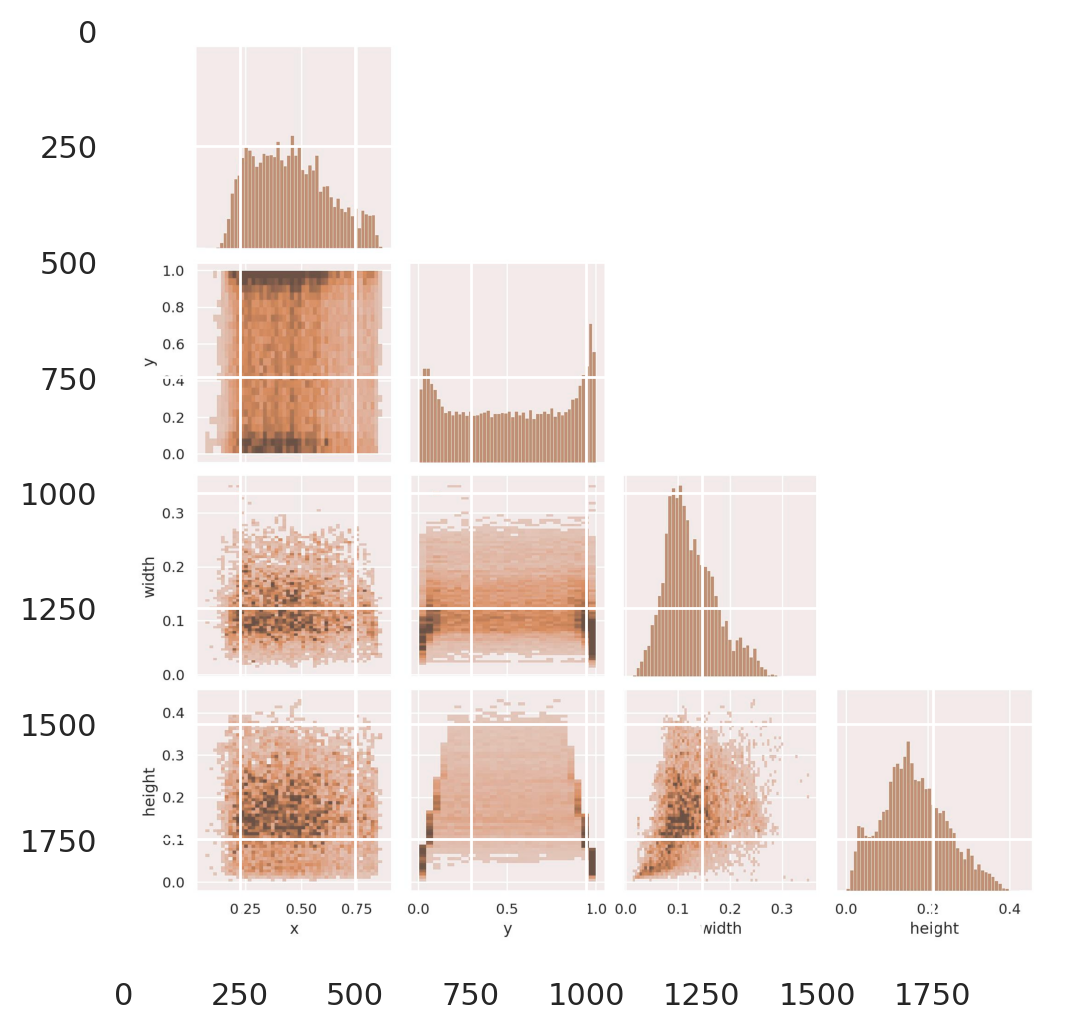

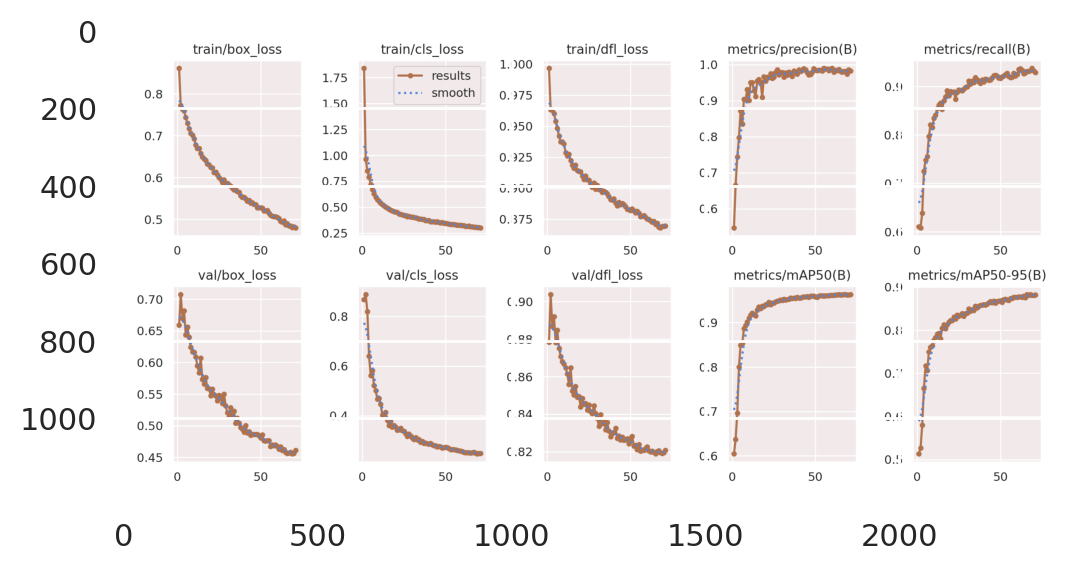

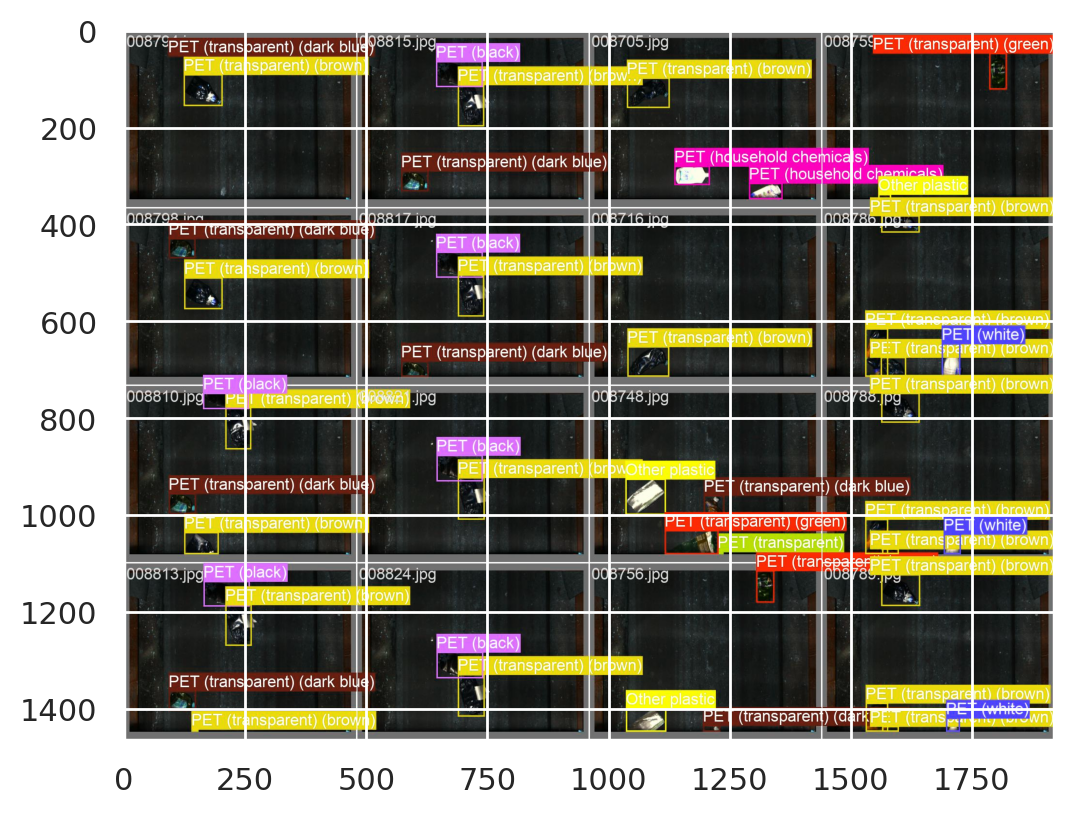

In [48]:
data_dir = os.path.join(PATH, 'runs/detect/train')
img_lst = ['F1_curve.png', 'PR_curve.png', 'confusion_matrix.png', 'labels_correlogram.jpg', 'results.png', 'val_batch0_labels.jpg']

for image in img_lst:
    img_dir = os.path.join(data_dir, image)
    img = cv2.imread(img_dir)
    plt.figure(figsize=(6,6), dpi= 200)
    plt.imshow(img)

* По графику зависимости F1-меры от достоверности предсказаний модели, можно сделать вывод, модель достаточно неплохо предсказывет классы при низком уровне уверенности в своих предсказаниях, но при этом метрика F1 проседает, когда модель слишком уверена. При этом стоит отметить, что все классы предсказываются примерно одинаково, за исключением PND packet, где при выскокой достоверности модели метрика F1 уменьшается раньше по сравнению с другими классами.
* PR кривая показывает отличные результаты, метрики Precision и Recall достаточно хорошо сбалансированы, все классы предсказываются практически одинаково хорошо. Площадь под агрегирующей кривой близка к единице и равна 0,962.
* По матрице несоответствий видно, что модель достаточно неплохо справляется с классами, но большое количество ошибок вызвано принятием фона за объект. Вероятно, это связано с темноым цветом конвейерной ленты, стоит поработать с гиперпараметрами для устранения данного класса ошибок, а именно с насыщенностью, т.к. высветление фона может помочь лучше различать на нем объекты, а также другими параметрами аугментации.
* По коррелограмме параметров рамки заметна корреляция между шириной и высотой, между остальными параметрами она отсутствует. Распределение ширины и высоты близко к нормальному, что свидетельствует о наличии некоторого среднего размера отходов. По высоте ленты отходы распределены практически равномерно за исключением низа и верха, что не удивительно с учетом того, что у нас статичная камера над движущейся ленте. Распределение отходов по ширине ленты напоминает равномерное.
* Также видим, что с ростом эпох выше 50 функция потерь значительно снижается, а целевая метрика увеличивается. Брать меньше 50 эпох для обучения данной модели нецелесообразно.
* На последней картинке приведен пример работы модели на валидационной выборке, где мы можем "на глаз" оценить качество работы модели.

In [ ]:
images_test_path = os.path.join(PATH, 'datasets/yolo11/images/test')
image_test_path = os.path.join(images_test_path, '008998.jpg')

results = model.predict(source=image_test_path, 
                        imgsz=IMGSZ)

test_image = results[0].plot(line_width=2)
plt.figure(figsize=(10,10), dpi= 200)
plt.imshow(test_image)

In [ ]:
total_result = []
for file_name in test['file_name'].tolist():
    results = model(os.path.join(images_test_path, file_name))
    for r in results:
        cls = (r.boxes.cls + 1).tolist()
        conf = r.boxes.conf.tolist()
        xywh = xywh2ltwh(r.boxes.xywh).tolist()
        result = []
        for i in range(len(cls)):
            combined_row = [cls[i], round(conf[i], 2)] + np.round(xywh[i], decimals=2).tolist()
            result.append(combined_row)
    total_result.append(result)
    # чистим память
    del results, result, cls, conf, xywh
    gc.collect()

Делаем предсказание для соревнование Kaggle.

In [ ]:
submission = pd.DataFrame( {'file_name': test['file_name'],
     'bbox': total_result
    })

In [ ]:
submission

In [ ]:
submission.to_csv(r'submission.csv', index= False)

По итогу получили метрику на тестовых данных, равную 0.87283, показав достаточно высокий результат.


## 4. Общий вывод

Загрузили и провели первичный обзор данных.

Набор данных `train.csv` сдержит 32265 строк и 6001 уникальное изображение, столбцы `bbox` и `category_id` имеют пропуски. Вероятно, это связано с тем, что на фото пустой конвейер, проверим это на следующем шаге.

`test.csv` содержит 2999 изображений для детекции.

Пример решения `sample_submission` содержит те же 2999 изображений, что и `test.csv`. Стоит отметить, что предсказание может иметь список списков, что говорит о нескольких объектах на одном фото, либо пустой список, что свидетельствует о пустом конвейере.

Определили, что целевые классы распределены неравномерно. Чаще всего на конвейере встречается мусор категории 2, реже всего - категория 12 либо конвейер вовсе остается пустым. Выяснили, что пропущенные значения в наборе данных свидетельствуют о пустом конвейере в момент фото.

Рассмотрели выборку фото с конвейера. Набор картинок достаточно разнообразен. Имеются различные типы отходов, расположенные на конвейере в случайном положении. Стоит отметить, что количество отходов на одном фото варьируется от 0 до нескольких.

Определили, что классы распределены неравномерно. Чаще всего на конвейере встречается мусор категории 2, реже всего - категория 12 либо конвейер вовсе остается пустым.

Рассмотрели выборку фото с конвейера. Набор картинок достаточно разнообразен. Имеются различные типы отходов, расположенные на конвейере в случайном положении. Стоит отметить, что количество отходов на одном фото варьируется от 0 до нескольких.

Дообучили модель `yolo11s.pt` на нашем наборе данных, провели её валидацию, по результатам которой можем сделать следующие выводы:

* По графику зависимости F1-меры от достоверности предсказаний модели, можно сделать вывод, модель достаточно неплохо предсказывет классы при низком уровне уверенности в своих предсказаниях, но при этом метрика F1 проседает, когда модель слишком уверена. При этом стоит отметить, что все классы предсказываются примерно одинаково, за исключением PND packet, где при выскокой достоверности модели метрика F1 уменьшается раньше по сравнению с другими классами.
* PR кривая показывает отличные результаты, метрики Precision и Recall достаточно хорошо сбалансированы, все классы предсказываются практически одинаково хорошо. Площадь под агрегирующей кривой близка к единице и равна 0,962.
* По матрице несоответствий видно, что модель достаточно неплохо справляется с классами, но большое количество ошибок вызвано принятием фона за объект. Вероятно, это связано с темноым цветом конвейерной ленты, стоит поработать с гиперпараметрами для устранения данного класса ошибок, а именно с насыщенностью, т.к. высветление фона может помочь лучше различать на нем объекты, а также другими параметрами аугментации.
* По коррелограмме параметров рамки заметна корреляция между шириной и высотой, между остальными параметрами она отсутствует. Распределение ширины и высоты близко к нормальному, что свидетельствует о наличии некоторого среднего размера отходов. По высоте ленты отходы распределены практически равномерно за исключением низа и верха, что не удивительно с учетом того, что у нас статичная камера над движущейся ленте. Распределение отходов по ширине ленты напоминает равномерное.
* Также видим, что с ростом эпох выше 50 функция потерь значительно снижается, а целевая метрика увеличивается. Брать меньше 50 эпох для обучения данной модели нецелесообразно.

Для улучшения качества модели рекомендуется увеличить размер выборки с изображениями, использовать более ресурсоёмкую модель, например, `yolo11x.pt` и произвести более тонкую настройку гиперпараметров, связанных с аугментацией изображений.